## Introduction to Neural Networks: Multi-layer Perceptrons

In this notebook, we will start looking at a Neural Network based model for the regression problem on the CDMS dataset. The problem remains the same- we want to predict the impact location of a potential dark matter candidate on the detector prototype based on the phonon resonance timing measurements obtained from its different channels. The simplest form of a neural net is called a multi-layer perceptron (MLP). A fully connected MLP, also called a Dense Network sometimes, follows a simple construction. The architecture is described in terms of *layers*. The very first layer is composed of the input values and the very last layer is essentially the desired output. Each numerical component of a layer is called a *node*, so the number of nodes in the input layer is essentially the same as the dimension of the input feature space. Each layer between the input and output layers is called a hidden layer. Each hidden layer is constructed as a linear combination of the outputs of the previous layer and its output is transformed via a non-linear activation (like a sigmoid function). If a NN with $N$ hidden layers is designed approximate the following functional relationship between inputs $x$ and output $y$ such that
\begin{equation}
y = f(x)
\end{equation}
then the hidden layers are defined as
\begin{equation}
h_{i+1} = \sigma (W_{i+1} h_i + b_{i+1})
\end{equation}
where $W_i, b_i$ respective represent the weights and biases of the $i$-th hidden layer, $\sigma$ represents a non-linear activation function, and the index $i$ runs from $0$ to $N-1$. The initial and final layers are given as
\begin{equation}
h_0 \equiv x \\
h_{N+1} \equiv y
\end{equation}

Our job is the determine the right set of model parameters, in this case the $W_i, b_i$ values, so that the NN can determine the functional relationship between the input and the output as closely as apossible. How this is done will be explained in greater details later. For the time being, we will look at data processing and model building. We will use the `PyTorch` libraries for creating our MLP network. Let's start by importing the necessary libraries.

In [1]:
import numpy as np
from sklearn.model_selection import *
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import pandas as pd
from matplotlib import pyplot as plt

Now we will load our data. PyTorch has a number of facilities that allow memor efficient data processing and loading. However, given it is a simple and small dataset, we'll stick to importing the data via `pandas` and storing them as `NumPy` arrays. Also note that in the following code block, we don't split the features and outputs right away. Additionally, the data standardization is only applied to the input features while the output is kept unnormalized.

In [2]:
## Get the dataset as numpy array

data = pd.read_csv('../data/reduced_dataset/reduced_data.csv', sep=',')

features = list(data.columns)[1:]
xy_data = data.values[:,1:]
n_features = len(features) - 1

def split_data(split_type='random', labels = []):
    if split_type == 'random':
        XY_train, XY_test  = train_test_split(xy_data, test_size=0.25)
    if split_type == 'label':
        XY_train = data.loc[~data[features[-1]].isin(labels)].values[:, 1:]
        XY_test = data.loc[data[features[-1]].isin(labels)].values[:, 1:]
        
    XY_train, XY_valid = train_test_split(XY_train, test_size=0.2, stratify=XY_train[:, -1])
    x_mean = np.mean(XY_train[:,:-1], axis = 0)
    x_std  = np.std(XY_train[:,:-1], axis = 0)
    XY_train[:,:-1] = (XY_train[:,:-1] - x_mean)/x_std
    XY_test[:,:-1]  = (XY_test[:,:-1] - x_mean)/x_std
    XY_valid[:,:-1]  = (XY_valid[:,:-1] - x_mean)/x_std
    
    return XY_train, XY_valid, XY_test, x_mean, x_std

You can see we have generated three separate outputs here. 

- The `XY_test` dataset is associated with a subset of the data corresponding to a certain subset of impact locations in the dataset which the neural network never learns about during training. The performance of the NN on this dataset will shed light on its ability to interpolate for new impact locations. 
- On the other hand, the `XY_valid` is called the validation dataset- they are obtained from the same sample space as the training data. The performance of the NN on this dataset can be used to assure that the NN doesn't overtrain- i.e. so precisely tunes its parameters to correctly predict the outputs for the training dataset that it fails to generalize for datasets beyond the training subset
- And finally, there is the training dataset `XY_train`. This is the dataset that we will use to train the NN, i.e. the NN's model parameters will be optimized to predict the outputs for this subset of the data as accurately as possible (without overtraining).

Now, we will create a class to construct the network. It will be inherited from PyTorch's `nn.Module` class. While this class can typically include user defined custom methods, defining an inheritance class from `nn.Module` definitely requires defining the `forward` method- which tells what the output of the model will be when some data is given as input to it.

In [3]:
## Defining a class for a generic MLP

class Network(nn.Module):
    def __init__(self, Layers, device, activation, 
                 end_in_sigmoid = False,
                 add_dropout = False,
                 add_batchnorm = False):
        super(Network, self).__init__()
        self.Layers = Layers
        self.device = device
        self.activation = activation
        self.end_in_sigmoid = end_in_sigmoid
        self.add_dropout = add_dropout,
        self.add_batchnorm = add_batchnorm,
        self.nn = self.build_model().to(device)
        
    def build_model(self):
        Seq = nn.Sequential()
        for ii in range(len(self.Layers)-1):
            this_module = nn.Linear(self.Layers[ii], self.Layers[ii+1])
            Seq.add_module("Linear" + str(ii), this_module)
            if not (ii == len(self.Layers)-2):
                if self.add_batchnorm[0]:
                    Seq.add_module("BatchNorm" + str(ii), nn.BatchNorm1d(self.Layers[ii+1]))
                Seq.add_module("Activation" + str(ii), self.activation)
                if self.add_dropout[0]:
                    Seq.add_module("Dropout" +str(ii), nn.Dropout(p=0.5, inplace=False))
            if self.end_in_sigmoid:
                Seq.add_module("Sigmoid" + str(ii), nn.Sigmoid())
        return Seq
    
    def forward(self, X):
        X = X.to(self.device)
        return self.nn(X)

Now we want to create the functionality of training the NN, i.e. determining its parameters. Below, we create a custom class for our regression problem which constructs our NN and also provides a `train()` method, that can be used to train the NN. The training is done minimizing a loss function. In this case we are going to use the mean squared error (MSE) loss, which determines the averaged squared difference between true values of the desired output and the NN-evaluated values.

\begin{equation}
\mathcal{L}_{MSE} = \frac{1}{N}\sum_{i=1}^N \left(y_i - f(x_i)\right)^2
\end{equation}

During each iteration, the parameters receive a correction based on how large their impact is on the loss function. 

\begin{equation}
\theta_i^{(m+1)} = \theta_i^{(m)} - \eta \frac{\partial \mathcal{L}}{\partial \theta}
\end{equation}
Here $\theta$ represents any of the model parameters and $\eta$ is called learning rate, which is one of the hyperparameters of the model. This method of obtaining correction for model parameters is called the method of Gradient Descent. However, we typically don't use the entire dataset to perform gradient descent. During each iteration over the entire dataset, we divide the dataset into smaller subsets called *minibatches*. We choose these subsets so that each of them has substantially lower number of data entries but still has just enough data to represent the underlying physical probability distribution of the training dataset. This method is called **stochastic gradient descent**, which is typically much faster than the naive gradient descent method. The size of the minibatch is yet another hyperparameter of the model, and so is the number of iterations (also called epochs) used to train the model.

AS you cans see, the `train()` method takes three arguments here. `n_epoch` and `batch_size` represent the hyperparameters number of epochs and minibatch size as described above. The other one is `lossfn` which is the loss function to be used to train the model.

In [4]:
class CDMS_Regressor:
    def __init__(self, Layers, XY_train, XY_valid, XY_test, device, activation=nn.Sigmoid()):
        self.XY_train = torch.tensor(XY_train, dtype = torch.float32, device = device)
        self.XY_test  = torch.tensor(XY_test,  dtype = torch.float32, device = device)
        self.XY_valid = torch.tensor(XY_valid, dtype = torch.float32, device = device)
        self.device = device
        self.MLP = Network(Layers, device, activation, 
                           end_in_sigmoid = False,
                           add_dropout = True,
                           add_batchnorm = True)
        
    def predict(self,X):
        return self.MLP.forward(X).to(self.device)
    
    def Train(self, n_epochs, batch_size, lossfn):
        Train_Losses = []
        Validation_Losses = []
        Test_Losses = []
        params = list(self.MLP.nn.parameters())
        optimizer = optim.Adam(params, lr=1e-3)
        for ii in range(n_epochs):
            self.MLP.train()
            DL = DataLoader(self.XY_train, batch_size=batch_size, shuffle=True, drop_last=True)
            for xy in DL:
                optimizer.zero_grad()
                y_pred = self.predict(xy[:,:-1]).reshape(-1)
                loss = torch.sqrt(lossfn(y_pred, xy[:,-1].reshape(-1)))
                loss.backward()
                optimizer.step()
                
            self.MLP.eval()    
            with torch.no_grad():
                train_loss = np.sqrt(float(lossfn(self.predict(self.XY_train[:,:-1]).reshape(-1), 
                                                  self.XY_train[:,-1])))
                test_loss =  np.sqrt(float(lossfn(self.predict(self.XY_test[:,:-1]).reshape(-1), 
                                                  self.XY_test[:,-1])))
                val_loss =   np.sqrt(float(lossfn(self.predict(self.XY_valid[:,:-1]).reshape(-1), 
                                                  self.XY_valid[:,-1])))
                Train_Losses.append(train_loss)
                Test_Losses.append(test_loss)
                Validation_Losses.append(val_loss)
                
                if ii % int(n_epochs/10) == 0 or ii == n_epochs - 1:
                    print("Epoch {0}/{1}, Training Loss = {2:0.4f}, Validation Loss = {3:0.4f}, Test Loss = {4:0.4f}".format(ii, n_epochs, train_loss, val_loss, test_loss))
            
        
        return Train_Losses, Test_Losses, Validation_Losses
 

Now we perform the actual fitting. We need to decide how many hidden layers we want and how many nodes we want for each layer. These details again are additional hyperparameters of the model. In this problem, we will use a simple network with one hidden layer and use 32 nodes for the hidden layer. The activation function we are going to use is called `LeakyReLU` function, defined as-

\begin{equation}
\mathrm{LeakyReLU} (x) = \begin{cases}
x; \quad  x \ge 0 \\
mx; \quad x < 0
\end{cases}
\end{equation}
where $m$ is generally a small positive number. Let's now train the model.

In [5]:
NhiddenLayers = 1
NNodes = 32
Layers = [n_features] + NhiddenLayers*[NNodes] + [1]
XY_train, XY_valid, XY_test,  x_mean, x_std = split_data('label', [-12.502, -29.5, -41.9])
lossfn = nn.MSELoss()
device = torch.device('cpu')
activation = nn.LeakyReLU(negative_slope=0.01)
n_epochs = 100
batch_size = 128

NNreg = CDMS_Regressor(Layers = Layers, 
                      XY_train = XY_train, 
                      XY_test = XY_test, 
                      XY_valid = XY_valid,
                      device = device, 
                      activation=activation)

Train_Losses, Test_Losses, Validation_Losses = NNreg.Train(n_epochs = n_epochs,
                                                           batch_size = batch_size,
                                                           lossfn = lossfn)


Epoch 0/100, Training Loss = 23.3319, Validation Loss = 23.3295, Test Loss = 29.9486
Epoch 10/100, Training Loss = 7.4589, Validation Loss = 7.5896, Test Loss = 11.4200
Epoch 20/100, Training Loss = 1.9534, Validation Loss = 2.0291, Test Loss = 2.0638
Epoch 30/100, Training Loss = 1.8313, Validation Loss = 1.8960, Test Loss = 2.1082
Epoch 40/100, Training Loss = 1.7167, Validation Loss = 1.7860, Test Loss = 2.1158
Epoch 50/100, Training Loss = 1.5860, Validation Loss = 1.6575, Test Loss = 1.9067
Epoch 60/100, Training Loss = 1.7483, Validation Loss = 1.7967, Test Loss = 2.0376
Epoch 70/100, Training Loss = 1.6507, Validation Loss = 1.7054, Test Loss = 1.9261
Epoch 80/100, Training Loss = 1.5277, Validation Loss = 1.5728, Test Loss = 1.8198
Epoch 90/100, Training Loss = 1.7244, Validation Loss = 1.7746, Test Loss = 2.0887
Epoch 99/100, Training Loss = 1.5881, Validation Loss = 1.6465, Test Loss = 1.8577


You can try to change different hyperparameters of the model and see how the model's performace changes. Try using different batch sizes, adding more hidden layers, chaning the activation function. Also, in the model description, there are a couple of flag variables called `add_dropout` and `add_batchnorm`. I would strongly suggest you to try changing them and see how the behavior and the performance of the model changes.

Now, we will evaluate the performance of the model. First, let's check the evolution of the loss function for training, validation, and test datasets.

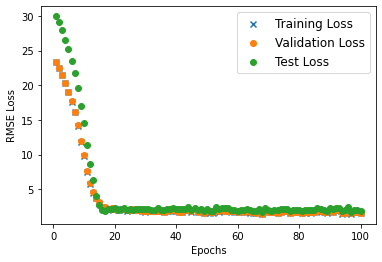

In [6]:
plt.scatter(np.arange(1,n_epochs+1), Train_Losses, marker='x', label="Training Loss")
plt.scatter(np.arange(1,n_epochs+1), Validation_Losses, label="Validation Loss")
plt.scatter(np.arange(1,n_epochs+1), Test_Losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.legend(fontsize=12)

And finally, we will check the performance of the model against the true data for different datasets.

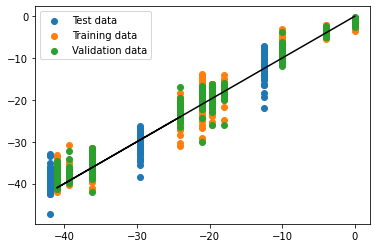

In [7]:
y_orig = NNreg.XY_test[:,-1].cpu().detach().numpy()
y_pred = NNreg.predict(NNreg.XY_test[:,:-1]).reshape(-1).cpu().detach().numpy()
plt.scatter(y_orig, y_pred, label='Test data')
y_orig_2 = NNreg.XY_train[:,-1].cpu().detach().numpy()
y_pred_2 = NNreg.predict(NNreg.XY_train[:,:-1]).reshape(-1).cpu().detach().numpy()
plt.scatter(y_orig_2, y_pred_2, label='Training data')
y_orig_2 = NNreg.XY_valid[:,-1].cpu().detach().numpy()
y_pred_2 = NNreg.predict(NNreg.XY_valid[:,:-1]).reshape(-1).cpu().detach().numpy()
plt.scatter(y_orig_2, y_pred_2, label='Validation data')
plt.plot(y_orig_2, y_orig_2, color='k')
plt.legend()